### Imports

In [1]:
import json
import string
import pandas as pd

from glob import glob
from nltk import ngrams
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm_notebook as tqdm

### Constants

In [2]:
RAW_DATA = '../data/raw_submissions_data_5000.json'
IMAGES_DIR = '../data/images'
OUT_PATH = '../data/dataset_5000_v1.json'

MIN_POST_KARMA = 0
MIN_COMMENTS = 0
MIN_COMMENT_KARMA = 0

tqdm.pandas()

### Utilities

In [3]:
def clean_and_tokenise_comment(comment):
    # To lower case
    comment = comment.lower()
    # strip punctuation
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    # tokenise
    comment = word_tokenize(comment)
    
    return comment

### Load Raw Data

In [4]:
with open (RAW_DATA) as j:
    raw_data = json.load(j)

### Image Paths

In [5]:
image_paths = glob('{}/*.png'.format(IMAGES_DIR))
len(image_paths)

3530

### Attach Image Paths

In [6]:
dataset = []
for submission in raw_data:
    image_path = '{}/{}.png'.format(IMAGES_DIR, submission['id'])
    if image_path in image_paths:
        submission['image_path'] = image_path
        dataset.append(submission)
len(dataset)

3530

### Filter Submissions

In [7]:
dataset = [
    submission 
    for submission in dataset 
    if submission['score'] >= MIN_POST_KARMA and submission['num_comments'] >= MIN_COMMENTS
]
len(dataset)

3530

### Explode

In [8]:
exploded_dataset = []
for submission in dataset:
    for i, comment in enumerate(submission['comments']):
        training_example = {
            'id': '{}_{}'.format(submission['id'], i),
            'image_path': submission['image_path'], 
            'score': submission['score'],
            'comment': comment['body'],
            'comment_score': comment['score']
        }
        exploded_dataset.append(training_example)
exploded_dataset = pd.DataFrame(exploded_dataset)
exploded_dataset.set_index('id', inplace=True)
print(len(exploded_dataset))
exploded_dataset.head()

559020


,image_path,score,comment,comment_score
id,,,,
lhle0e_0,../data/images/lhle0e.png,1,Babies don't have craterface. Try Grindr. Mayb...,1
lhle0e_1,../data/images/lhle0e.png,1,Too bad that baby face is stillborn.,1
lhle0e_2,../data/images/lhle0e.png,1,Get you a new hairstyle that looks good. You r...,1
lhle0e_3,../data/images/lhle0e.png,1,Feel sorry for a baby that looks like you,1
lhle0e_4,../data/images/lhle0e.png,1,Baby faced? How long was she pregnant for?,1


### Filter Comments

In [9]:
exploded_dataset = exploded_dataset[exploded_dataset.comment_score > MIN_COMMENT_KARMA]
len(exploded_dataset)

549452

### Clean & Tokenise Comments

In [10]:
exploded_dataset['comment_tokens'] = exploded_dataset.comment.progress_apply(clean_and_tokenise_comment)

  0%|          | 0/549452 [00:00<?, ?it/s]

### Basic Comment Analysis

#### Comment Lengths

count    549452.000000
mean         12.813911
std          11.270412
min           0.000000
25%           7.000000
50%          11.000000
75%          16.000000
max         870.000000
Name: comment_tokens, dtype: float64


<AxesSubplot:>

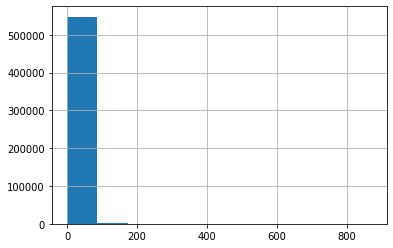

In [11]:
comment_lengths = exploded_dataset.comment_tokens.apply(len)
print(comment_lengths.describe())
comment_lengths.hist()

#### Top Comments

In [12]:
pd.options.display.max_colwidth = 150
exploded_dataset.sort_values('score', ascending=False)[:20].comment

id
l9a321_262    The man who created the polio vaccine is named Jonas Salk... he chose not to patent or seek profits from his discovery so it could reach the most ...
l9a321_356                                                                                                               How is your kneecap fatter than your head?
l9a321_370                                                                                                                          Polio? You mean the shit virus?
l9a321_369                                                                                                                     I’m guessing your last name is Patel
l9a321_368                         They all wish they actually got polio so that they could subsequently die and be able to erase your hideousness from their minds
l9a321_367                                                                                          Keep doing the good work india needs more well trained doctors.
l9a321_366   

In [13]:
exploded_dataset.loc['l9a321_262'].comment

"The man who created the polio vaccine is named Jonas Salk... he chose not to patent or seek profits from his discovery so it could reach the most people and do the most good. One of the things you should have learned in school was a little humility instead of narcissistically seeking attention from strangers online, for a discovery that you didn't make."

#### Top Ngrams

In [14]:
all_comment_tokens = []
for tokens in exploded_dataset.comment_tokens:
    all_comment_tokens.extend(tokens)

In [15]:
stop_words = stopwords.words('english')
all_comment_tokens_no_stop = [token for token in tqdm(all_comment_tokens) if token not in stop_words]

  0%|          | 0/7040629 [00:00<?, ?it/s]

In [16]:
trigram_counts = Counter(ngrams(all_comment_tokens_no_stop, 3))
trigram_counts.most_common(20)

[(('look', 'like', '’'), 1903),
 (('u', 'look', 'like'), 1429),
 (('look', 'like', 'someone'), 1350),
 (('look', 'like', 'one'), 1319),
 (('face', 'looks', 'like'), 1271),
 (('look', 'like', 'youre'), 1160),
 (('looks', 'like', '’'), 1079),
 (('look', 'like', 'type'), 1056),
 (('look', 'like', 'guy'), 1030),
 (('think', 'bio', 'helped'), 1011),
 (('bio', 'helped', 'roast'), 1010),
 (('helped', 'roast', 'upvote'), 1010),
 (('roast', 'upvote', 'comment'), 1010),
 (('upvote', 'comment', 'think'), 1010),
 (('comment', 'think', '’'), 1010),
 (('’', 'sure', 'leave'), 1010),
 (('sure', 'leave', 'others'), 1010),
 (('think', '’', 'downvote'), 1009),
 (('’', 'downvote', '’'), 1009),
 (('downvote', '’', 'sure'), 1009)]

### Save Dataset

In [17]:
wexploded_dataset.to

TypeError: Object of type 'DataFrame' is not JSON serializable